In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil

In [18]:
RESULTS = 'results/'
PLOTS = f'{RESULTS}plots/'
REPORTS = f'{RESULTS}reports'
BFE = f'{RESULTS}best_fitness_execution/'

In [23]:
parametric = pd.read_csv(f"{BFE}/test_parametrico.csv")
informal = pd.read_csv(f"{BFE}test_informal.csv")

In [24]:
parametric.describe()

,"[0.8, 0.01]","[0.8, 0.05]","[0.8, 0.1]","[0.9, 0.01]","[0.9, 0.05]","[0.9, 0.1]"
count,2.900000e+01,2.900000e+01,2.900000e+01,2.900000e+01,2.900000e+01,2.900000e+01
mean,9.481117e+06,9.400303e+06,9.175838e+06,9.207908e+06,9.339942e+06,9.072921e+06
std,5.068376e+05,5.386744e+05,6.016087e+05,4.892848e+05,5.498697e+05,4.109667e+05
min,8.592505e+06,8.665922e+06,8.013956e+06,8.322384e+06,8.181205e+06,8.149677e+06
25%,9.249413e+06,9.038323e+06,8.742101e+06,8.911039e+06,9.001746e+06,8.817853e+06
50%,9.392873e+06,9.219275e+06,9.127509e+06,9.167807e+06,9.311774e+06,9.240692e+06
75%,9.762942e+06,9.702512e+06,9.613116e+06,9.609019e+06,9.727986e+06,9.370411e+06
max,1.086430e+07,1.065155e+07,1.037747e+07,1.009209e+07,1.064070e+07,9.724379e+06


In [45]:
def print_hist_plots(df):
    fig, axs = plt.subplots(ceil(len(df.columns)/2), 2, figsize=(20, 20))
    for col,ax in zip(df.columns, axs.flatten()):
        ax.hist(df[col], density=True)
        ax.set_title(col)
        xlim = ax.get_xlim()
        
        # kernel density estimate
        df[col].plot.density(color='k', alpha=0.5, ax=ax)
        
        ax.set_xlim(xlim)
        ax.legend(labels=['KDE'], frameon=False)
        ax.set_title(col, fontsize=14, pad=15)
        
    fig.savefig(f"{PLOTS}{col}.png")

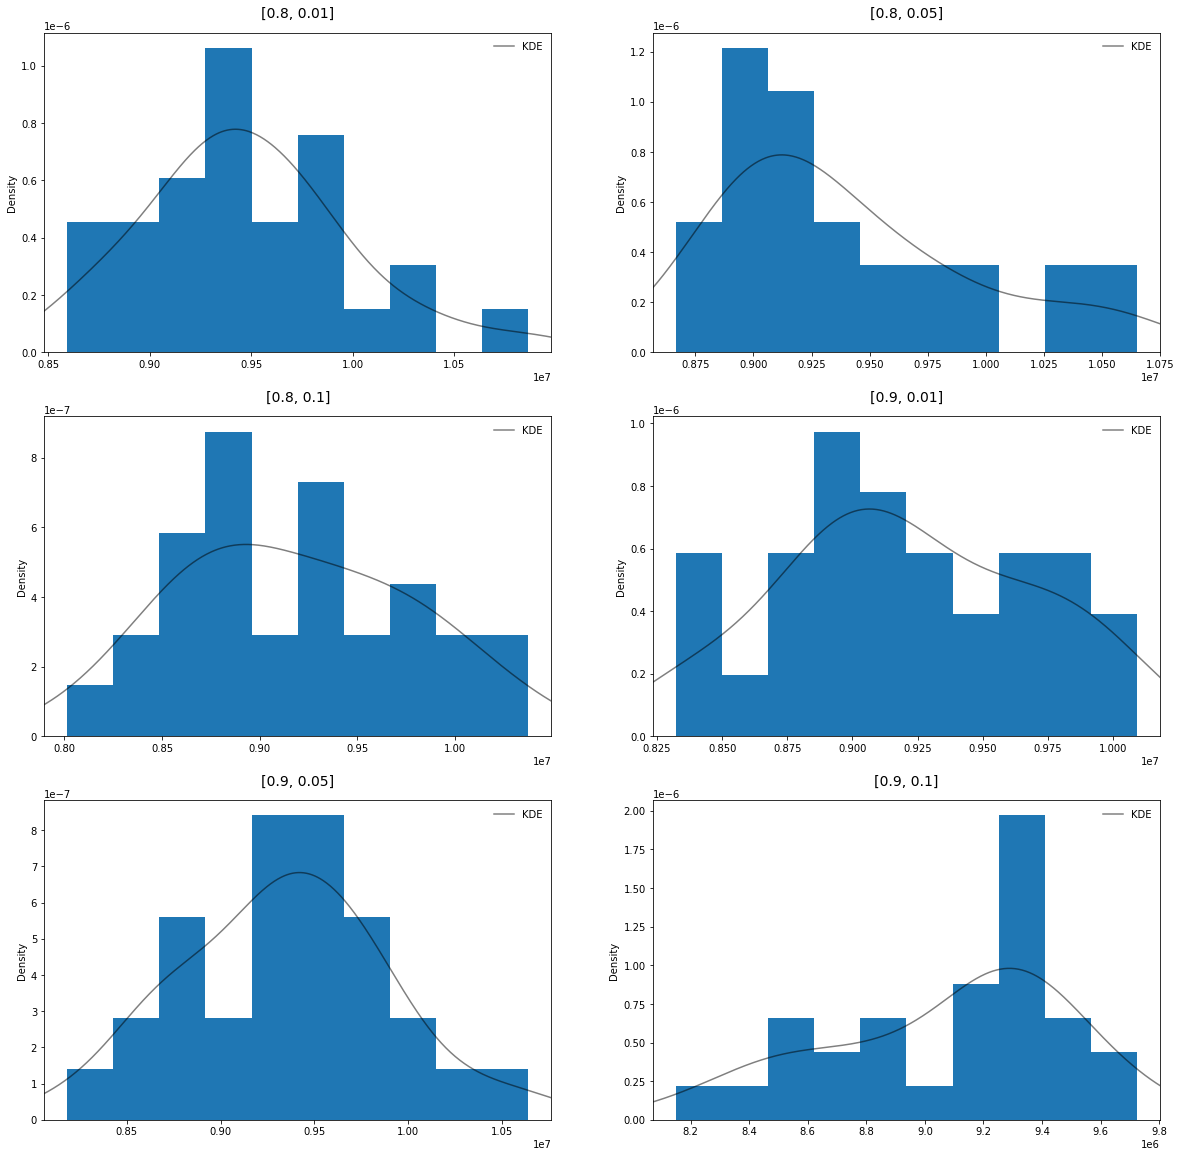

In [46]:
print_hist_plots(parametric)

In [6]:
from scipy.stats import kstest, f_oneway

In [47]:
def normality_test(sample): 
        standarized_sample = (sample - np.mean(sample)) / np.std(sample, ddof=1)
        return kstest(standarized_sample, "norm", alternative='two-sided').pvalue

def anova_test(samples):
        return f_oneway(*samples).pvalue

In [49]:
print(anova_test([parametric[col] for col in parametric.columns]))

0.031229326295978393
